In [1]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from absl import logging

import jax
from jax import random
import jax.numpy as jnp

from flax import jax_utils
from flax.training import common_utils

import ml_collections

from data import input_pipeline
import models

import wandb

import numpy as np
import utils

from configs.eval_merge import get_config

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from utils import restore_checkpoint

import merging
import models


from trainer import compute_metrics 

2024-08-06 07:59:45.513877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 07:59:45.635130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 07:59:45.635212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 07:59:48.127135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/h/ekansh/condaenvs/jax-0.4.23/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLE

In [3]:
def get_metrics(metrics):
  return common_utils.stack_forest(metrics)

  
@functools.partial(jax.jit, static_argnums=(0,))
def eval_step(apply_fn, params, batch):
    variables = {'params': params}
    logits = apply_fn(variables, batch['image'])
    metrics = compute_metrics(logits, batch['label'])  
    return metrics


def compute_loss_and_accuracy(params, apply_fn, dataset, nbatches=None):
  eval_iter = input_pipeline.prefetch(dataset, 10, None)
  eval_metrics = []
  ix = 0
  for eval_batch in eval_iter:
      metrics = eval_step(apply_fn, params, eval_batch)
      eval_metrics.append(metrics)
      ix+=1
      if nbatches is not None:
          if ix >= nbatches:
              break
  
  eval_metrics = get_metrics(eval_metrics)
  summary = {
          f'eval_{k}': v
          for k, v in jax.tree_util.tree_map(
              lambda x: x.mean(), eval_metrics
          ).items()
      }

  return summary['eval_loss'], summary['eval_accuracy']



In [71]:
from configs.eval_merge import get_config
config_a = get_config(f'ViTB32,cifar10.cifar100.eurosat.resisc45,average-merging')
config_a.cifar10.model_dir = '../experiments/ViT-B-32/cifar10/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config_a.cifar10.init_model_dir = '../experiments/ViT-B-32/cifar10/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config_a.cifar100.model_dir = '../experiments/ViT-B-32/cifar100/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config_a.cifar100.init_model_dir = '../experiments/ViT-B-32/cifar100/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config_a.eurosat.model_dir = '../experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0'
config_a.eurosat.init_model_dir = '../experiments/ViT-B-32/eurosat/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'
config_a.resisc45.model_dir = '../experiments/ViT-B-32/resisc45/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/'
config_a.resisc45.init_model_dir = '../experiments/ViT-B-32/resisc45/adam_LR_1e-5_WD_1e-1/cosine/40_epochs_1_warmup/seed_0/init'

config_a.cifar10.pp.crop = 224
config_a.cifar100.pp.crop = 224
config_a.eurosat.pp.crop = 224
config_a.resisc45.pp.crop = 224

In [74]:
from configs.eval_merge import get_config
config_b = get_config(f'ViTB32,cifar10.cifar100.eurosat.resisc45,average-merging')
config_b.cifar10.model_dir = '../experiments/ViT-B-32/cifar10/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config_b.cifar10.init_model_dir = '../experiments/ViT-B-32/cifar10/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config_b.cifar100.model_dir = '../experiments/ViT-B-32/cifar100/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config_b.cifar100.init_model_dir = '../experiments/ViT-B-32/cifar100/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config_b.eurosat.model_dir = '../experiments/ViT-B-32/eurosat/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0'
config_b.eurosat.init_model_dir = '../experiments/ViT-B-32/eurosat/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'
config_b.resisc45.model_dir = '../experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'
config_b.resisc45.init_model_dir = '../experiments/ViT-B-32/resisc45/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/init'

config_b.cifar10.pp.crop = 224
config_b.cifar100.pp.crop = 224
config_b.eurosat.pp.crop = 224
config_b.resisc45.pp.crop = 224

In [85]:
from configs.eval_merge import get_config
config_c = get_config(f'VGG16,cifar10.cifar100.eurosat.resisc45,average-merging')
config_c.width_multiplier = 2
config_c.cifar10.model_dir = '../experiments/VGG16x2/FT_13/cifar10_96/sgd/cosine_1e-2/seed_0/'
config_c.cifar10.init_model_dir = '../experiments/VGG16x2/scratch/imagenet2012_96/sgd/cosine_1e-1/seed_13/'
config_c.cifar100.model_dir = '../experiments/VGG16x2/FT_13/cifar100_96/sgd/cosine_1e-2/seed_0/'
config_c.cifar100.init_model_dir = '../experiments/VGG16x2/scratch/imagenet2012_96/sgd/cosine_1e-1/seed_13/'
config_c.eurosat.model_dir = '../experiments/VGG16x2/FT_13/eurosat_96/sgd/cosine_1e-2/seed_0/'
config_c.eurosat.init_model_dir = '../experiments/VGG16x2/scratch/imagenet2012_96/sgd/cosine_1e-1/seed_13/'
config_c.resisc45.model_dir = '../experiments/VGG16x2/FT_13/resisc45_96/sgd/cosine_1e-2/seed_0/'
config_c.resisc45.init_model_dir = '../experiments/VGG16x2/scratch/imagenet2012_96/sgd/cosine_1e-1/seed_13/'

config_c.cifar10.pp.crop = 96
config_c.cifar100.pp.crop = 96
config_c.eurosat.pp.crop = 96
config_c.resisc45.pp.crop = 96

In [86]:
'../experiments/VGG16x2/finetuned_imagenet2012_96_13/cifar10_96/sgd/epo'

'../experiments/ViT-B-32/cifar10/sgd_LR_1e-3_WD_1e-4/cosine/40_epochs_1_warmup/seed_0/'

In [88]:
datasets = config_a.datasets
dataset_info_ls = [input_pipeline.get_dataset_info(dataset, config_a[dataset].pp['train']) for dataset in config_a.datasets]
num_classes = [dataset_info['num_classes'] for dataset_info in dataset_info_ls] 
num_train_examples = [dataset_info['num_examples'] for dataset_info in dataset_info_ls]

_, ds_test_ls = input_pipeline.get_datasets_for_mtl(config_c, datasets)



In [89]:
ntasks = len(num_classes)
model_ls = []
for nclass in num_classes:
    model_ls += [models.create_model(
                    model_cls= getattr(models, config_c.model), 
                    num_classes=nclass, 
                    width_multiplier=config_c.width_multiplier,
                    projection_dim=512, 
                    half_precision=config_c.half_precision) ]

## Get expert + init  models
expert_params_ls = []
init_params_ls = []
for dataset in datasets:
    print(f"Loading init and expert models for {dataset}.")
    expert_params_ls += [restore_checkpoint(config_c[dataset].model_dir)['params']]
    init_params_ls += [restore_checkpoint(config_c[dataset].init_model_dir)['params']]  



Loading init and expert models for cifar10.
Loading init and expert models for cifar100.
Loading init and expert models for eurosat.
Loading init and expert models for resisc45.


In [90]:

## Compute task vectors
task_vectors = [utils.tree_subtract({
    'encoder' : params['encoder'],
    'visual_projection' : params['visual_projection']
}, {
    'encoder' : init_params['encoder'],
    'visual_projection' : init_params['visual_projection']
}) for params, init_params  in zip(expert_params_ls, init_params_ls)]  

perf_gain = lambda acc, init_acc: (acc - init_acc) / init_acc
perf_drop = lambda acc, expert_acc: (expert_acc - acc) / expert_acc


In [42]:

## Compute task vectors
task_vectors = [utils.tree_subtract({
    'encoder' : params['encoder'],
    'visual_projection' : params['visual_projection'], 
}, {
    'encoder' : init_params['encoder'],
    'visual_projection' : init_params['visual_projection']
}) for params, init_params  in zip(expert_params_ls, init_params_ls)]  

perf_gain = lambda acc, init_acc: (acc - init_acc) / init_acc
perf_drop = lambda acc, expert_acc: (expert_acc - acc) / expert_acc


In [91]:
from utils import cosine_similarity

cosine_sim_tv = np.zeros((ntasks, ntasks))
for i in range(ntasks):
    for j in range(i, ntasks):
        cosine_sim_tv[i, j] = cosine_similarity(task_vectors[i], task_vectors[j])
        cosine_sim_tv[j, i] = cosine_sim_tv[i, j]

/tmp/ipykernel_8785/1104765320.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

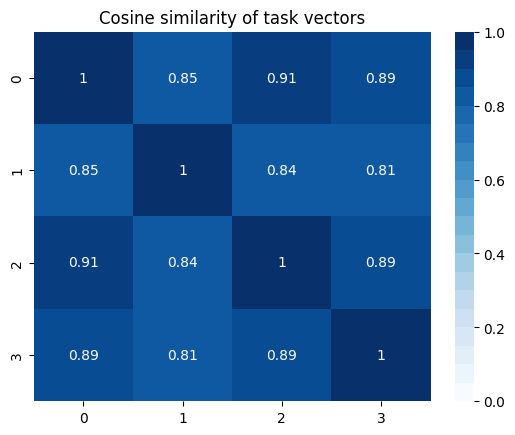

In [92]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(cosine_sim_tv, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')

/tmp/ipykernel_22105/1104765320.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

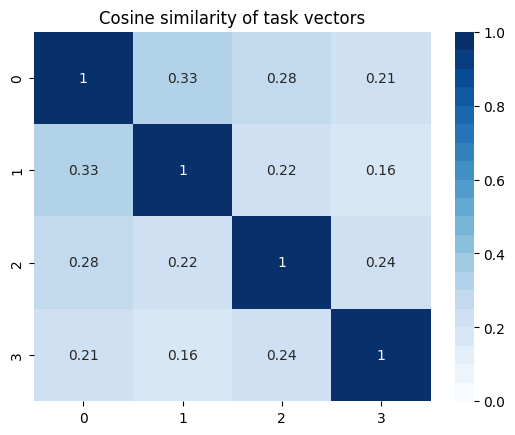

In [52]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(cosine_sim_tv, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')

In [7]:
from min_norm_solver import find_min_norm_element_FW

normalized_task_vectors = [utils.normalize_tree(t)[0] for t in task_vectors]
print(find_min_norm_element_FW(normalized_task_vectors)[0])
print(find_min_norm_element_FW(task_vectors)[0])

[0.23491642 0.24036642 0.25369351 0.27102367]
[0.15530696 0.03245251 0.63068806 0.18155248]


In [112]:
ix = 3
iy = 1
loss = []
accs = []
for lam in np.linspace(0,1,10):
    merged_params = {
        'encoder': utils.lerp(lam, init_params_ls[iy]['encoder'], expert_params_ls[iy]['encoder']),
        'visual_projection': utils.lerp(lam, init_params_ls[iy]['visual_projection'], expert_params_ls[iy]['visual_projection']),
        'logit_scale': expert_params_ls[ix]['logit_scale'], 
        'classifier': expert_params_ls[ix]['classifier']
        }
    merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches = 10)
    loss += [merged_loss]   
    accs += [merged_accuracy]   
    

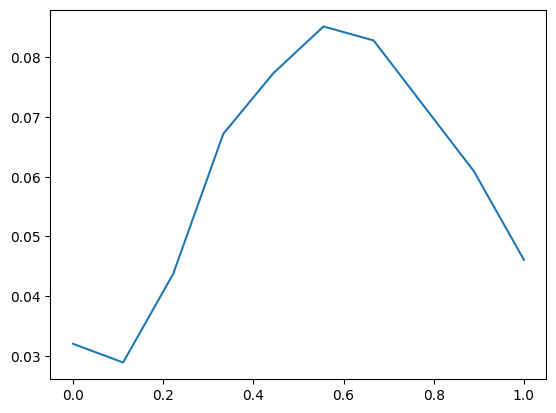

In [113]:
import matplotlib.pyplot as plt
# ix=0
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

In [111]:
accs

[0.009375,
 0.1546875,
 0.4296875,
 0.5992187,
 0.6984375,
 0.7640625,
 0.80390626,
 0.815625,
 0.828125,
 0.8257812]

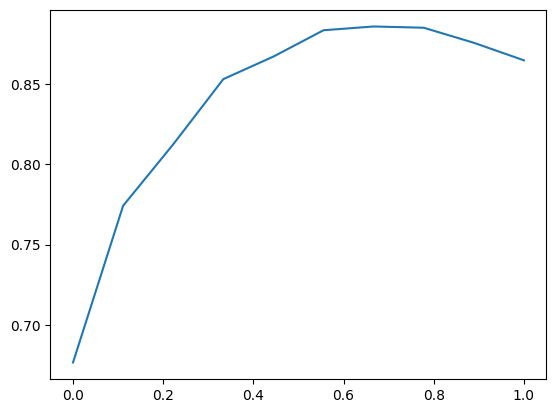

In [80]:
import matplotlib.pyplot as plt
# ix=0
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

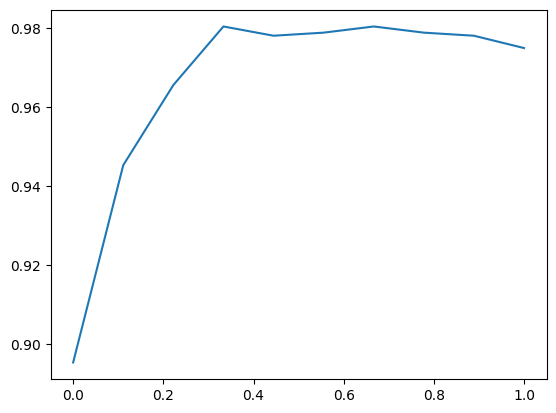

In [14]:
import matplotlib.pyplot as plt
# ix=0
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

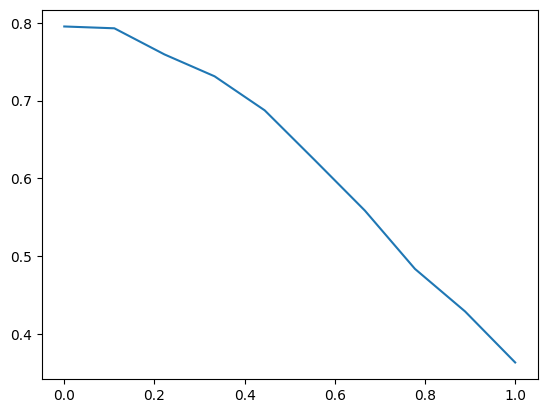

In [33]:
import matplotlib.pyplot as plt
# ix=0
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

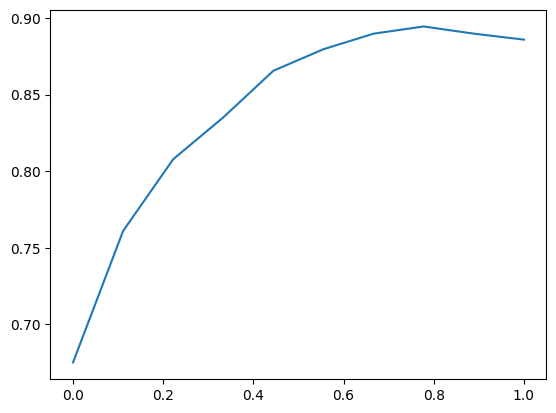

In [16]:
import matplotlib.pyplot as plt
# ix=1
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

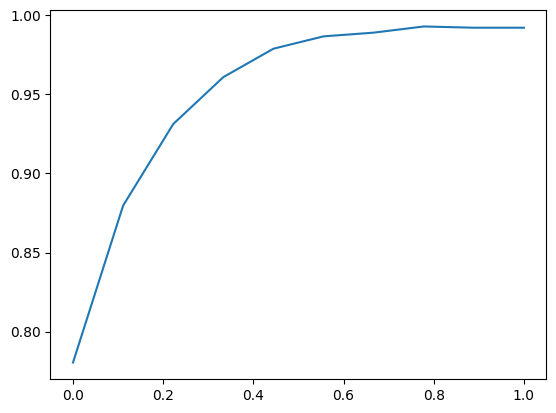

In [27]:
import matplotlib.pyplot as plt
# ix=2
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

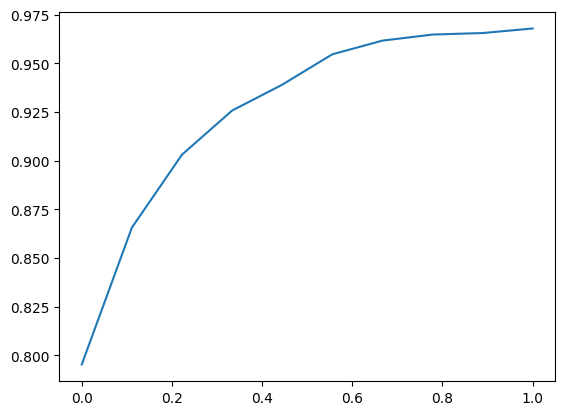

In [29]:
import matplotlib.pyplot as plt
# ix=3
# plt.plot(np.linspace(0,1,10), loss)
plt.plot(np.linspace(0,1,10), accs)

In [114]:
from utils import tree_zeros_like, tree_scalar_multiply, tree_add
from pyhessian.hvp import compute_batch_hvp

from trainer import cross_entropy_loss

def compute_hessian_vector_product(loss_fn, dataset, params, v, nbatches=None, axis_name=None):
    eval_iter =  input_pipeline.prefetch(dataset, 10, None)
    if axis_name is not None: 
        batch_hvp = jax.pmap(compute_batch_hvp, static_argnums=(0, 4))
    else:
        batch_hvp = jax.jit(compute_batch_hvp, static_argnums=(0, 4))
    N = 0
    Hv = tree_zeros_like(v)
    ix = 0
    
    if axis_name is not None:
        N_fn = lambda batch: batch['label'].shape[0] * batch['label'].shape[1]
    else:
        N_fn = lambda batch: batch['label'].shape[0] 
    
    for batch in eval_iter:
        batch_n = N_fn(batch)
        N += batch_n
        _Hv = batch_hvp(loss_fn, batch, params, v, axis_name)
        Hv = tree_add(Hv, tree_scalar_multiply(batch_n, _Hv))
        ix+=1
        if nbatches is not None:
          if ix >= nbatches:
              break
        
    return tree_scalar_multiply(1./N, Hv)


In [115]:

def loss_fn( apply_fn, batch, params):
    logits = apply_fn(
    {'params': params},
    batch['image'])
    loss = cross_entropy_loss(logits, batch['label'])
    return loss




In [116]:
HVPS = [lambda params, v: compute_hessian_vector_product(functools.partial(loss_fn, model_ls[0].apply), ds_test_ls[0], params, v, nbatches=None)]
HVPS += [lambda params, v: compute_hessian_vector_product(functools.partial(loss_fn, model_ls[1].apply), ds_test_ls[1], params, v, nbatches=None)]
HVPS += [lambda params, v: compute_hessian_vector_product(functools.partial(loss_fn, model_ls[2].apply), ds_test_ls[2], params, v, nbatches=None)]
HVPS += [lambda params, v: compute_hessian_vector_product(functools.partial(loss_fn, model_ls[3].apply), ds_test_ls[3], params, v, nbatches=None)]


In [117]:
len(HVPS)

4

In [121]:
matrix = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        tv = {'encoder': utils.tree_subtract(expert_params_ls[j]['encoder'], init_params_ls[j]['encoder']),
              'visual_projection':  utils.tree_subtract(expert_params_ls[j]['visual_projection'], init_params_ls[j]['visual_projection']) , 
              'logit_scale': utils.tree_zeros_like(expert_params_ls[i]['logit_scale']), 
              'classifier': utils.tree_zeros_like(expert_params_ls[i]['classifier']),
        } 
        init_params = {
            'encoder' : init_params_ls[i]['encoder'],
            'visual_projection' : init_params_ls[i]['visual_projection'], 
            'logit_scale': expert_params_ls[i]['logit_scale'], 
            'classifier': expert_params_ls[i]['classifier'],
        }
        matrix[i,j] = utils.tree_inner_prod(tv, HVPS[i](init_params, tv)) / np.square(utils.tree_norm(tv))
        print(matrix[i,j])

2024-08-06 11:14:49.089179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


nan


2024-08-06 11:15:49.868683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


nan


KeyboardInterrupt: 

In [124]:
matrix = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        tv = {'encoder': utils.tree_subtract(expert_params_ls[j]['encoder'], expert_params_ls[i]['encoder']),
              'visual_projection':  utils.tree_subtract(expert_params_ls[j]['visual_projection'], expert_params_ls[i]['visual_projection']) , 
              'logit_scale': utils.tree_zeros_like(expert_params_ls[i]['logit_scale']), 
              'classifier': utils.tree_zeros_like(expert_params_ls[i]['classifier']),
        }
        if i==j:
            matrix[i,i] = 0
        else:
            matrix[i,j] = utils.tree_inner_prod(tv, HVPS[i](expert_params_ls[i], tv)) / (np.square(utils.tree_norm(tv)))
        
        print(matrix[i,j])

0.0


2024-08-06 14:06:32.280034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.0010832572588697076


2024-08-06 14:07:30.790290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.002787149278447032


2024-08-06 14:08:29.493057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.0036369641311466694


2024-08-06 14:09:30.743403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.00467516016215086
0.0


2024-08-06 14:10:29.822879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.008475279435515404


2024-08-06 14:11:28.388580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.010547117330133915


2024-08-06 14:11:49.466479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.002279233420267701


2024-08-06 14:12:10.384713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.0018155142897740006
0.0


2024-08-06 14:12:31.464358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.002328552771359682


2024-08-06 14:12:56.941817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.008119365200400352


2024-08-06 14:13:19.880744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.0060842582024633884


2024-08-06 14:13:42.869358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


0.012961565516889095
0.0


/tmp/ipykernel_8785/1747009959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

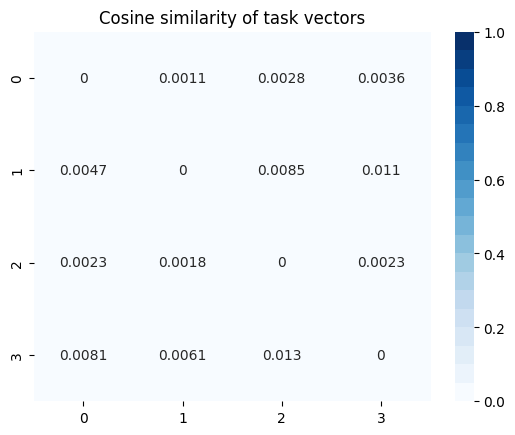

In [125]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(matrix, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')

/tmp/ipykernel_8785/1898412409.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

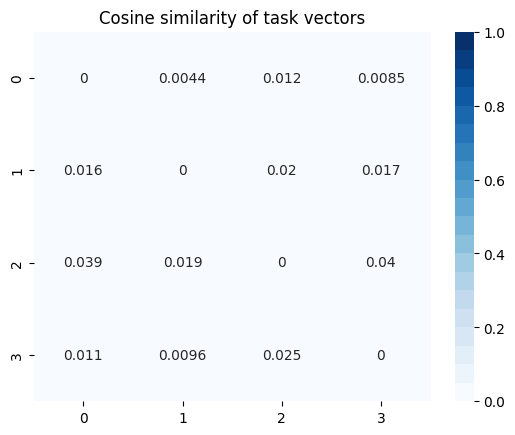

In [83]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(matrix, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')


/tmp/ipykernel_8785/1747009959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

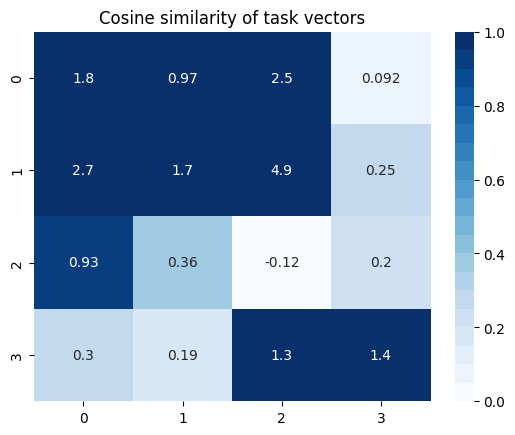

In [77]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(matrix, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')

/tmp/ipykernel_8785/1747009959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', 20)


Text(0.5, 1.0, 'Cosine similarity of task vectors')

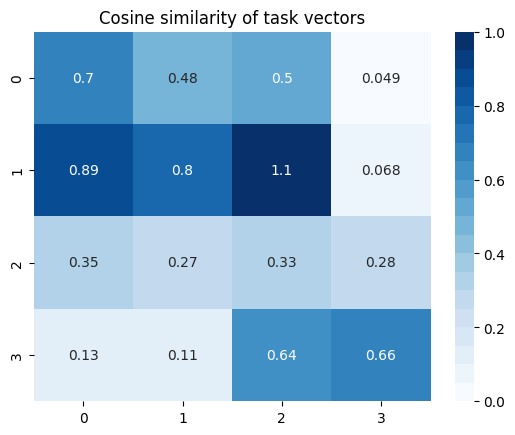

In [70]:
import seaborn as sns
from matplotlib import cm
cmap = cm.get_cmap('Blues', 20)
sns.heatmap(matrix, annot=True, cmap = cmap, vmax=1, vmin=-0.).set_title('Cosine similarity of task vectors')

In [64]:
matrix

array([[26.12344742, 21.99749184,  5.93273115,  0.78311849],
       [33.39338303, 36.80836487, 12.43658161,  1.0908922 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [123]:

tvs = [{'encoder': utils.tree_subtract(expert_params_ls[j]['encoder'], expert_params_ls[i]['encoder']),
    'visual_projection':  utils.tree_subtract(expert_params_ls[j]['visual_projection'], expert_params_ls[i]['visual_projection']) } for i in range(4)]

tv_vec = utils.add_trees(tvs)

for ix in range(4):
    print(datasets[ix])
    merged_accuracy_ls = []
    for lam in np.linspace(.1, 1.0, 20):
        merged_params = {
            'encoder': utils.tree_add(init_params_ls[ix]['encoder'], utils.tree_scalar_multiply(lam, tv_vec['encoder'])),
            'visual_projection': utils.tree_add(init_params_ls[ix]['visual_projection'], utils.tree_scalar_multiply(lam ,tv_vec['visual_projection'])),
            'logit_scale': expert_params_ls[ix]['logit_scale'], 
            'classifier': expert_params_ls[ix]['classifier']
            }
        merged_loss, merged_accuracy = compute_loss_and_accuracy(merged_params, model_ls[ix].apply, ds_test_ls[ix], nbatches=10)
        print(merged_accuracy)
        merged_accuracy_ls += [merged_accuracy]
    print(max(merged_accuracy_ls))


cifar10
0.04453125
0.05234375
0.06953125
0.08125
0.07890625
0.07890625
0.08203125
0.0859375
0.08671875
0.09609375
0.103125
0.1109375
0.10703125
0.103125
0.10390625
0.1015625
0.10078125
0.0984375
0.09921875
0.09921875
0.1109375
cifar100


2024-08-06 11:20:58.820950: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.00859375


2024-08-06 11:21:00.133770: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.01015625


2024-08-06 11:21:01.458429: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0125


2024-08-06 11:21:02.807340: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0140625


2024-08-06 11:21:04.167735: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.01328125


2024-08-06 11:21:05.486023: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0125


2024-08-06 11:21:06.810998: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0125


2024-08-06 11:21:08.141464: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0109375


2024-08-06 11:21:09.465934: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0109375


2024-08-06 11:21:10.799411: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.009375


2024-08-06 11:21:12.123846: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.00859375


2024-08-06 11:21:13.479113: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.0078125


2024-08-06 11:21:14.850262: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.009375


2024-08-06 11:21:16.197616: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.009375


2024-08-06 11:21:17.541490: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.009375


2024-08-06 11:21:18.884977: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.01015625


2024-08-06 11:21:20.245816: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.009375


2024-08-06 11:21:21.701348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.01171875


2024-08-06 11:21:23.038073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.01171875


2024-08-06 11:21:24.390647: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


0.01171875
0.0140625
eurosat
0.840625
0.9039062
0.934375
0.9453125
0.9421875
0.9453125
0.94375
0.9390625
0.92109376
0.8882812
0.8257812
0.7578125
0.7132813
0.653125
0.56953126
0.5109375
0.47578126
0.4359375
0.40859374
0.396875
0.9453125
resisc45
0.01953125
0.03046875
0.04140625
0.05
0.05625
0.05703125
0.05546875
0.05546875
0.05234375
0.04609375
0.04296875
0.04453125
0.0453125
0.0484375
0.046875
0.04375
0.0484375
0.0515625
0.05234375
0.053125
0.05703125
